# Homework week 3

The purpose of this notebook is to do the Statistical Rethinking 2022 [homework](https://github.com/rmcelreath/stat_rethinking_2022/tree/main/homework) using Python.

In [86]:
import arviz as az
import daft
from causalgraphicalmodels import CausalGraphicalModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

<IPython.core.display.Javascript object>

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Q1

All three problems below are based on the same data. The data in `data(foxes)` are 116 foxes from 30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to 8 individuals. Each group maintains its own (almost exclusive) urban territory. Some territories are larger than others. The `area` variable encodes this information. Some territories also have more `avgfood` than others. We want to model the `weight` of each fox. For the problems below, assume this DAG, where F is `avgfood`, G is `groupsize`, A is `area`, and W is `weight`. Use the backdoor criterion and estimate the total causal influence of A on F. What effect would increasing the area of a territory have on the amount of food inside it?

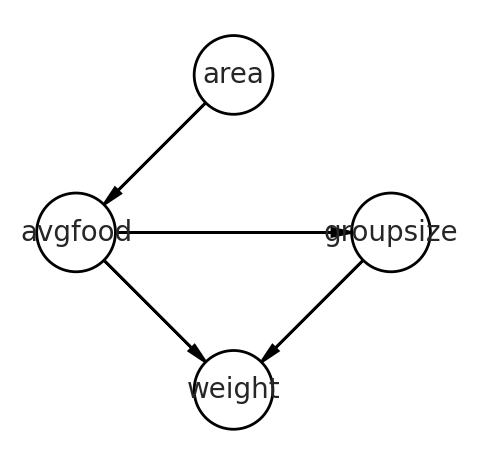

<IPython.core.display.Javascript object>

In [6]:
fox_dag = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "area": (1, 1),
    "avgfood": (0, 0),
    "groupsize": (2, 0),
    "weight": (1, -1),
}
for node in fox_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in fox_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

## Answer

This first problem just asks us to compute the effect of A on F. There are no backdoors to A and we do not need to worry about the other two variables. We simply regress F on A.

I'm going to be pretty conservative with priors, especially the coefficient on area. Intuitively, I would think that increasing the area would increase the amount of possible food, but it's just an assumption. I'll just give it a wide prior. Standardizing the variables will also help me interpret the results.

$$ F \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_A A $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_{A} \sim \text{Normal}(0, 3) $$
$$ \sigma \sim \text{Exp}(1) $$

In [224]:
DATA_DIR = '/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking_2/End_of_chapter_problems/data/'
df_foxes = pd.read_csv(DATA_DIR + "foxes.csv", sep=";", header=0)
df_foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


<IPython.core.display.Javascript object>

In [223]:
(df_foxes['avgfood'] - df_foxes['avgfood'].mean()).mean()

5.646824004558985e-17

<IPython.core.display.Javascript object>

In [54]:
# standardize variables
df_foxes['area_std'] = standardize(df_foxes['area'])
df_foxes['avgfood_std'] = standardize(df_foxes['avgfood'])
df_foxes['groupsize_std'] = standardize(df_foxes['groupsize'])
df_foxes['weight_std'] = standardize(df_foxes['weight'])
df_foxes.head()

,group,avgfood,groupsize,area,weight,area_std,avgfood_std,groupsize_std,weight_std
0,1,0.37,2,1.09,5.02,-2.249313,-1.933180,-1.530701,0.415931
1,1,0.37,2,1.09,2.84,-2.249313,-1.933180,-1.530701,-1.433238
2,2,0.53,2,2.05,5.33,-1.210738,-1.122886,-1.530701,0.678887
3,2,0.53,2,2.05,6.07,-1.210738,-1.122886,-1.530701,1.306586
4,3,0.49,2,2.12,5.85,-1.135008,-1.325459,-1.530701,1.119973


<IPython.core.display.Javascript object>

In [22]:
with pm.Model() as mq1:

    # Priors are variables a, b, sigma (all stochastic)
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=1)
    sigma = pm.Exponential("sigma", 1)

    # linear model (mu is deterministic)
    mu = a + bA * df_foxes['area_std']

    # likelihood
    f = pm.Normal("f", mu=mu, sd=sigma, observed=df_foxes['avgfood_std'])

    # prior predictive simulation
    prior_checks = pm.sample_prior_predictive(samples=200)

    # generate posterior and sample
    idata_mq1 = pm.sample(1000, tune=1000, return_inferencedata=True, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Prior predictive checks')

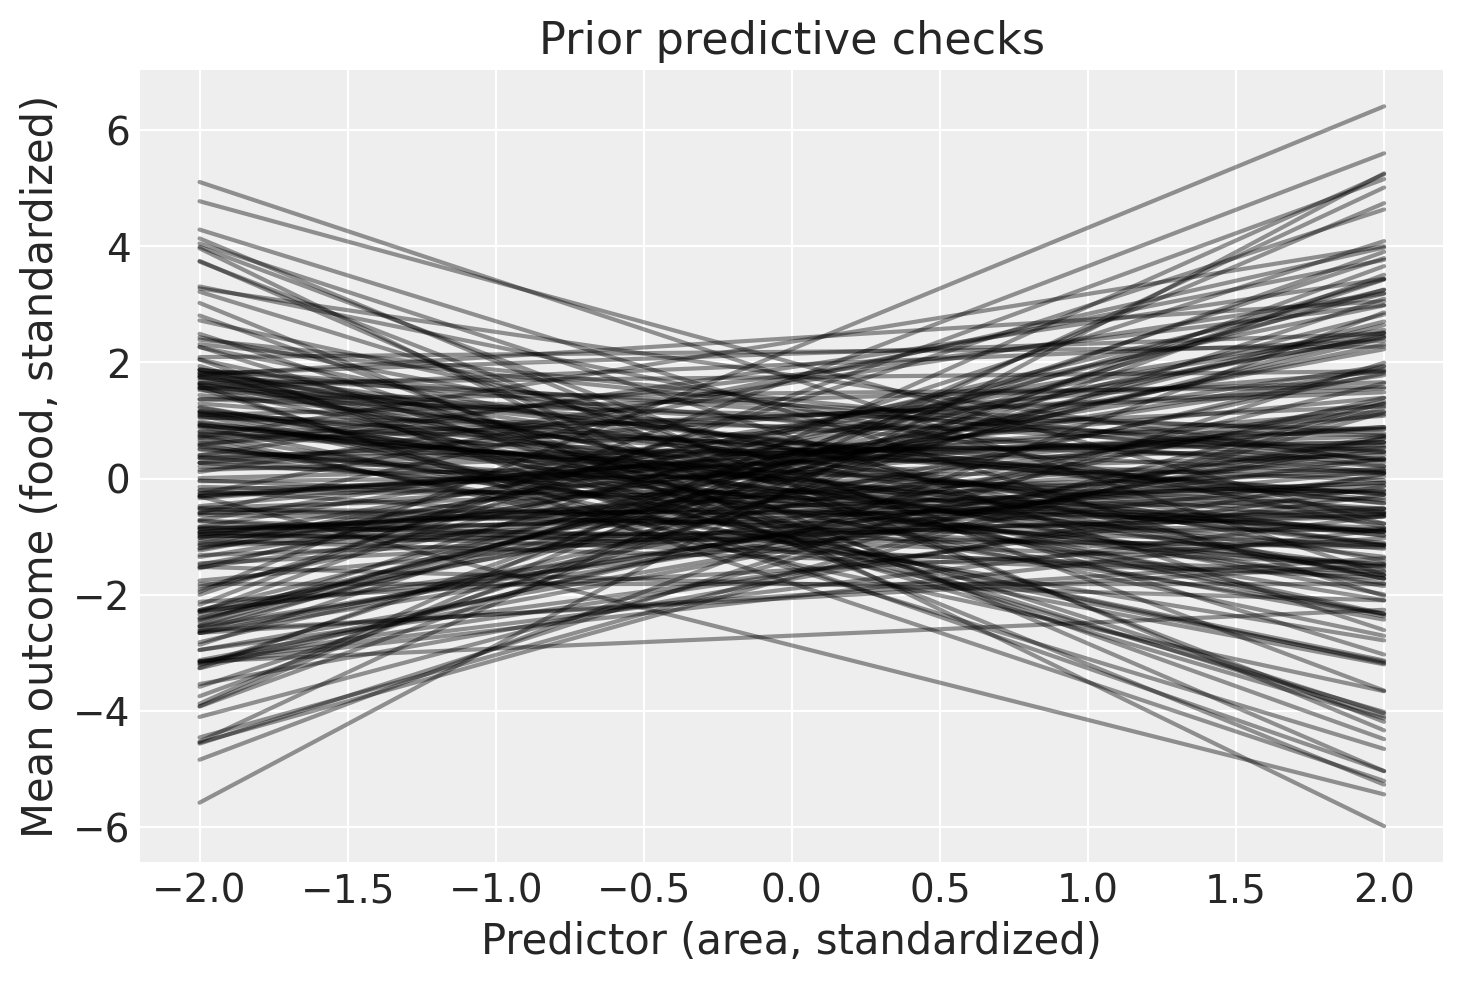

<IPython.core.display.Javascript object>

In [23]:
# prior checks
f, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

for a, bA in zip(prior_checks["a"], prior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Prior predictive checks")

In [24]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.044,-0.067,0.072,0.001,0.001,5279.0,2029.0,5249.0,3013.0,1.0
bA,0.882,0.045,0.812,0.954,0.001,0.000,5584.0,5583.0,5625.0,3224.0,1.0
sigma,0.478,0.033,0.421,0.525,0.000,0.000,5549.0,5401.0,5675.0,2813.0,1.0


<IPython.core.display.Javascript object>

**This says that increasing the area by one standard deviation will produce about 0.882 standardized units of average food.**

In [48]:
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
x

array([-1.93317993, -1.84636271, -1.75954549, -1.67272828, -1.58591106,
       -1.49909384, -1.41227662, -1.32545941, -1.23864219, -1.15182497,
       -1.06500776, -0.97819054, -0.89137332, -0.80455611, -0.71773889,
       -0.63092167, -0.54410445, -0.45728724, -0.37047002, -0.2836528 ,
       -0.19683559, -0.11001837, -0.02320115,  0.06361606,  0.15043328,
        0.2372505 ,  0.32406772,  0.41088493,  0.49770215,  0.58451937,
        0.67133658,  0.7581538 ,  0.84497102,  0.93178823,  1.01860545,
        1.10542267,  1.19223989,  1.2790571 ,  1.36587432,  1.45269154,
        1.53950875,  1.62632597,  1.71314319,  1.7999604 ,  1.88677762,
        1.97359484,  2.06041205,  2.14722927,  2.23404649,  2.32086371])

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Posterior predictive checks')

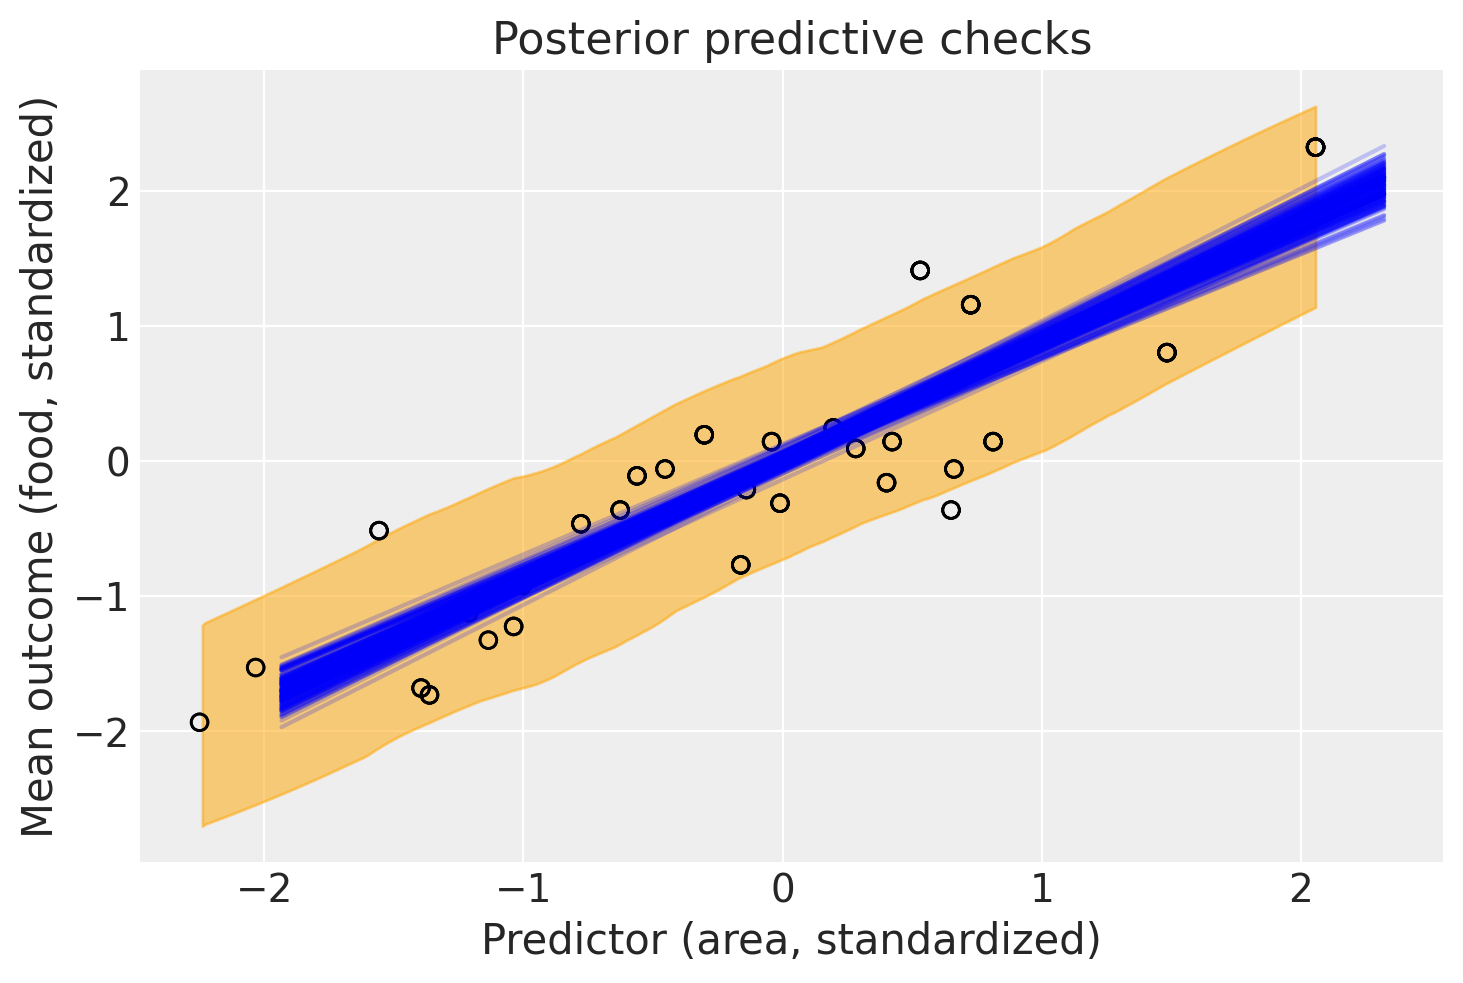

<IPython.core.display.Javascript object>

In [52]:
with mq1:
    posterior_checks = pm.sample_posterior_predictive(trace=idata_mq1, var_names=['a', 'bA', 'f'], samples=200)

# posterior checks
f, ax = plt.subplots()

# Plotting mean lines
x = np.linspace(df_foxes["avgfood_std"].min(), df_foxes["avgfood_std"].max(), 50)
for a, bA in zip(posterior_checks["a"], posterior_checks["bA"]):
    y = a + bA * x
    ax.plot(x, y, c="blue", alpha=0.2)

# Uncertainty around all predictions
az.plot_hdi(df_foxes["area_std"], posterior_checks["f"], color='orange', ax=ax)

# All raw data
ax.scatter(df_foxes["area_std"], df_foxes["avgfood_std"], facecolors='none', edgecolors='k')

ax.set_xlabel("Predictor (area, standardized)")
ax.set_ylabel("Mean outcome (food, standardized)")
ax.set_title("Posterior predictive checks")

In [39]:
# Make predictions using a function
def predict_sim(x, idata):
    
    # mean (easy to get)
    hi_mean = az.summary(idata).loc['a', 'mean'] + az.summary(idata).loc['bA', 'mean'] * x
    
    # make it accessible
    idata_df = idata.to_dataframe()

    # uncertainty requires thinking generatively
    mu_post_hi =idata_df[('posterior', 'a')] + idata_df[('posterior', 'bA')].mean() * x
    sigma_post_hi = idata_df[('posterior', 'sigma')]
    hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))

    return hi_mean, hpdi_89

<IPython.core.display.Javascript object>

Why are the posterior predicitions "squiggly"? It's just sampling variation. This is the line that samples.

`hpdi_89 = az.hdi(stats.norm.rvs(mu_post_hi, sigma_post_hi))`

In [40]:
az.summary(idata_mq1)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.044,-0.067,0.072,0.001,0.001,5279.0,2029.0,5249.0,3013.0,1.0
bA,0.882,0.045,0.812,0.954,0.001,0.000,5584.0,5583.0,5625.0,3224.0,1.0
sigma,0.478,0.033,0.421,0.525,0.000,0.000,5549.0,5401.0,5675.0,2813.0,1.0


<IPython.core.display.Javascript object>

(0.001, array([-0.7341488 ,  0.75810129]))
(0.001, array([-0.73009043,  0.79275384]))
(0.001, array([-0.75428258,  0.77425763]))
(0.001, array([-0.78244186,  0.76801638]))
(0.001, array([-0.79503278,  0.7799869 ]))
(0.001, array([-0.75699905,  0.78306209]))
(0.001, array([-0.78045948,  0.79319085]))
(0.001, array([-0.73987243,  0.74541122]))
(0.001, array([-0.73988983,  0.8102929 ]))
(0.001, array([-0.75301784,  0.77635132]))


[Text(0.5, 0, 'sampling trial'),
 Text(0, 0.5, '89% HPDI'),
 Text(0.5, 1.0, 'Posterior predictions when A=0')]

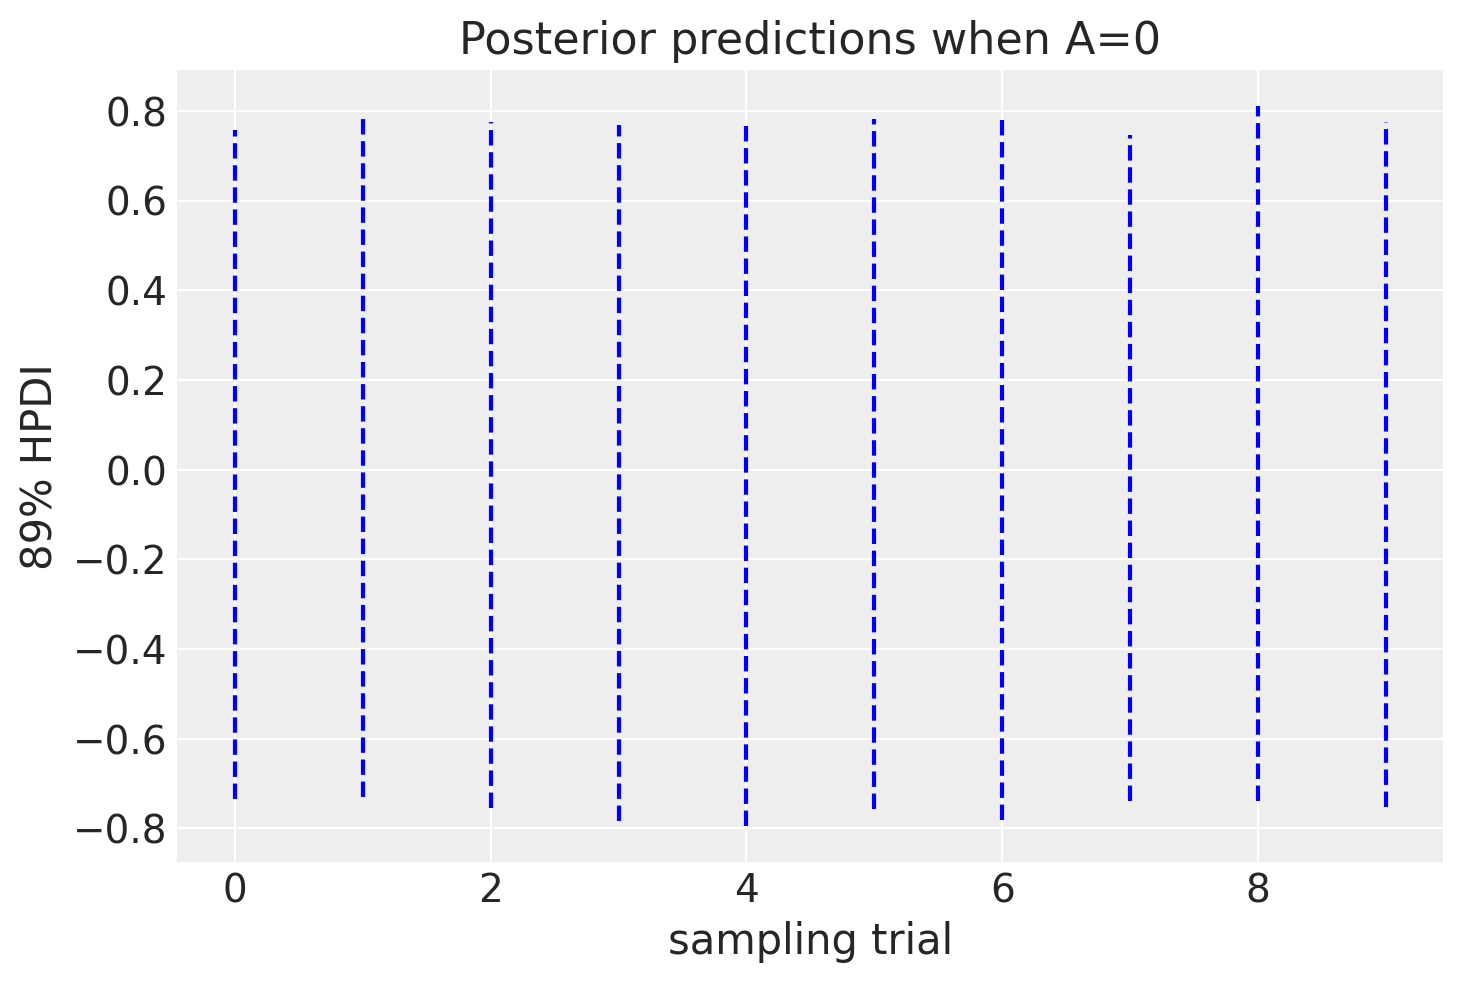

<IPython.core.display.Javascript object>

In [45]:
f, ax1 = plt.subplots()

for i, x in enumerate([0]*10):
    pred = predict_sim(x, idata_mq1)
    print(pred)
    ax1.vlines(i, ymin=pred[1][0], ymax=pred[1][1], linestyle='dashed', color='blue')

ax1.set(xlabel='sampling trial', ylabel="89% HPDI", title='Posterior predictions when A=0')

# Q2
Now infer both the total and direct causal effects of adding food F to a territory on the weight W of foxes. Which covariates do you need to adjust for in each case? In light of your estimates from this problem and the previous one, what do you think is going on with these foxes? Feel free to speculate—all that matters is that you justify your speculation.

## Answer


Here we're now considering the whole DAG. We're interested n the effect of food. Let's list all the paths and figure out what we need to adjust.

- F > W  (direct path)
- F > G > W  (indirect path)

Therefore, to get the total effect, we will build one model where do not condition on any variable. To get the direct effect, we will build a second model where we will condition on (group size). The regression models will look similar to the ones we've done before. I'm not going to make too many assumptions of how food affects weight. In the direct path, it is safe to assume that more food means more weight. However, for the second model, I'm unsure about how group size will affect weight. More foxes in a group could mean that food gets divided more for an individual fox, but it could also mean simply that the proverbial pie just gets bigger. I'll simply have wide, Normal priors for both F and G coefficients.

Model 1 (total effect):

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_F F $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_{F} \sim \text{Normal}(0, 2) $$
$$ \sigma \sim \text{Exp}(1) $$


Model 2 (direct effect):

$$ W \sim \text{Normal}(\mu, \sigma) $$
$$ \mu = \alpha + \beta_F F + \beta_F F $$
$$ \alpha \sim \text{Normal}(0, 1) $$
$$ \beta_{F} \sim \text{Normal}(0, 2) $$
$$ \beta_{G} \sim \text{Normal}(0, 2) $$
$$ \sigma \sim \text{Exp}(1) $$



In [56]:
with pm.Model() as mq2a:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df_foxes['avgfood_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2a = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2a = pm.sample_posterior_predictive(trace=idata_mq2a, samples=100)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bF, a]
INFO:pymc3:NUTS: [sigma, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


<IPython.core.display.Javascript object>

In [61]:
with pm.Model() as mq2b:

    # priors
    a = pm.Normal("a", 0, 1)
    bF = pm.Normal("bF", 0, 2)
    bG = pm.Normal("bG", 0, 2)
    sigma = pm.Exponential("sigma", 1)

    # linear model
    mu = a + bF*df_foxes['avgfood_std'] + bG*df_foxes['groupsize_std']

    # likelihood
    W = pm.Normal("W", mu, sigma, observed=df_foxes['weight_std'])

    # posterior
    idata_mq2b = pm.sample(draws=1000, tune=1000, return_inferencedata=True, progressbar=False)

    # posterior predictions
    post_pred_mq2b = pm.sample_posterior_predictive(trace=idata_mq2b, samples=100)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bG, bF, a]
INFO:pymc3:NUTS: [sigma, bG, bF, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8950267398269441, but should be close to 0.8. Try to increase the number of tuning steps.


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'direct effect of food on weight')

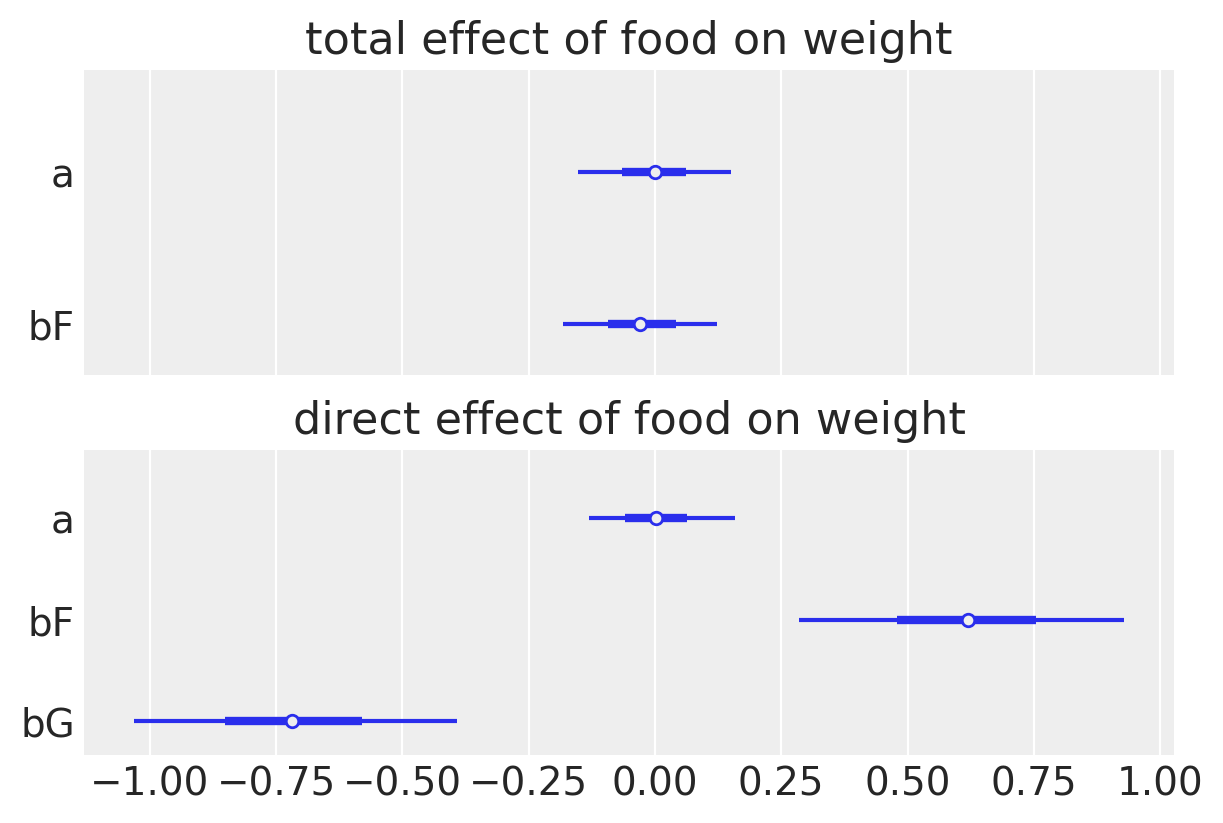

<IPython.core.display.Javascript object>

In [66]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
az.plot_forest(idata_mq2a, var_names=['a', 'bF'], combined=True, ax=ax1)
ax1.set_title("total effect of food on weight")

az.plot_forest(idata_mq2b, var_names=['a', 'bF', 'bG'], combined=True, ax=ax2)
ax2.set_title("direct effect of food on weight")

It is clear from the direct effect model that food has a positive impact on weight. However, when looking at the total effect, it appears that the effect of food gets blunted by the size of the group. Being part of a group with more members means that the food gets divided up for an individual fox. This is an instance of masked association (?).

When considering area though (Q1), a bigger territory can increase the overall quantity of food for an individual fox, because it is not affected by group size (A has no arrows pointing into it from G).


In [79]:
df_foxes.head()

,group,avgfood,groupsize,area,weight,area_std,avgfood_std,groupsize_std,weight_std
0,1,0.37,2,1.09,5.02,-2.249313,-1.933180,-1.530701,0.415931
1,1,0.37,2,1.09,2.84,-2.249313,-1.933180,-1.530701,-1.433238
2,2,0.53,2,2.05,5.33,-1.210738,-1.122886,-1.530701,0.678887
3,2,0.53,2,2.05,6.07,-1.210738,-1.122886,-1.530701,1.306586
4,3,0.49,2,2.12,5.85,-1.135008,-1.325459,-1.530701,1.119973


<IPython.core.display.Javascript object>

In [82]:
# Look for masked relationship? 
# sns.pairplot(df_foxes[['avgfood_std', 'groupsize_std', 'weight_std']])
# food and groupsize look correlated, but neither have obvious correlation with weight

<IPython.core.display.Javascript object>

Bonus: running the model forwards?

In [78]:
# bF_sim = 0.62
# bG_sim = -0.714
# sigma_sim = 1

# n = 100

# F_obs = df_foxes['avgfood_std'].copy()
# G_sim = stats.norm.rvs(bF_sim * F_obs)
# W_sim = stats.norm.rvs(bF_sim * F_obs + bG_sim * G_sim, sigma)

<IPython.core.display.Javascript object>

# Q3

Reconsider the Table 2 Fallacy example (from Lecture 6), this time with an
unobserved confound U that influences both smoking S and stroke Y. Here’s
the modified DAG:

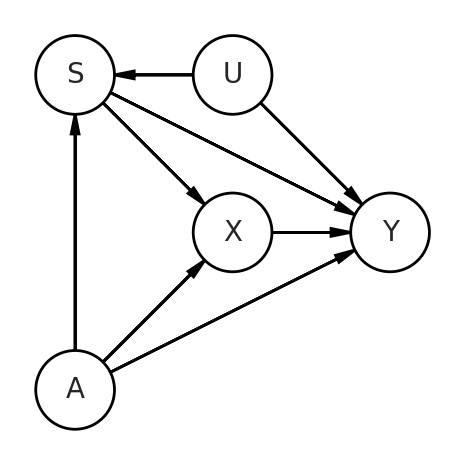

<IPython.core.display.Javascript object>

In [77]:
dag = CausalGraphicalModel(
    nodes=["S", "A", "X", "Y", "U"],
    edges=[
        ("A", "X"),
        ("A", "S"),
        ("A", "Y"),
        ("S", "X"),
        ("S", "Y"),
        ("X", "Y"),
        ("U", "S"),
        ("U", "Y"),
    ],
)
pgm = daft.PGM()
coordinates = {
    "A": (0, 0),
    "X": (1, 1),
    "S": (0, 2),
    "Y": (2, 1),
    "U": (1, 2),
}
for node in dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()

First use the backdoor criterion to determine an adjustment set that allows
you to estimate the causal effect of X on Y, i.e. P(Y|do(X)). Second explain
the proper interpretation of each coefficient implied by the regression model
that corresponds to the adjustment set. Which coefficients (slopes) are causal
and which are not? There is no need to fit any models. Just think through
the implications.

## Answer

Since we're looking for the causal effect of X on Y, we would look for all paths (forward and backward), and then see for which paths we need to close.

- X > Y (direct)
- X < S > Y, condition on S to close
- X < S < U > Y, unobserved confound opens this path
- X < A > S < U > Y, collider formed by U, conditioning on S would open it but conditioning on A would close it again
- X < A > S > Y, condition on A to close
- X < S < A > Y, condition on A to close
- X < A > Y, condition on A to close

Conditioning on A and S would close the backdoor paths and close one opened by the colider formed by U, allowing an estimate of the effect of X onto Y.

| Coefficient on Y  |  Interpretation |
| ---- | ------- |
| X | direct and total effect |
| S | confounded effect because U is a fork that acts on S and Y |
| A | confounded effect because of path opened by conditioning on S (originally closed due to collider created by U) |


It's helpful to look at the scenario *without* U (lecture example). 

**Lecture 6 example (no confound U)**

- X > Y (direct)
- X < S > Y, condition on S to close
- X < A > S > Y, condition on A to close
- X < S < A > Y, condition on A to close
- X < A > Y, condition on A to close

There, the coefficient of A is the amount that contributes to Y directly, and not through X or the paths through S. The coefficient of S also is representative of the contribution to Y and not through X. (You can think of how we can turn the question around and ask to get the direct influence of A or S. We'd stratify by X and the model would look the same.)

In summary, A's coefficient is the direct effect on Y. Likewise, S's coefficient is a direct effect on Y (skips mediation path).

Note that the [Westreich and Greenland, 2013 paper](https://academic.oup.com/aje/article/177/4/292/147738) discusses these scenarios.

# Q4 (optional)

Write a synthetic data simulation for the causal model shown in Problem 3. Be sure to include the unobserved confound in the simulation. Choose any functional relationships that you like—you
don’t have to get the epidemiology correct. You just need to honor the causal structure. Then design a regression model to estimate the influence of X on Y and use it on your synthetic data. How large of a sample do you need to reliably estimate P(Y|do(X))? Define “reliably” as you like, but justify your definition.

## Answer

The first thing I'm thinking about is that the effect size will play a role in how large of a sample we need. We can use a lecture example to gain some intuition on how to go about htis.

### Replicating lecture 6 example

Using lecture 6, slide 83 example. R code shown below

```
f <- function(n=100,bZX=1,bXY=1) {
Z <- rnorm(n)
X <- rnorm(n, bZX*Z )
Y <- rnorm(n, bXY*X )
bX <- coef( lm(Y ~ X) )['X']
bXZ <- coef( lm(Y ~ X + Z) )['X']
return( c(bX,bXZ) )
}
sim <- mcreplicate( 1e4 , f(n=50) , mc.cores=8 )
dens( sim[1,] , lwd=3 , xlab="posterior mean" )
dens( sim[2,] , lwd=3 , col=2 , add=TRUE )

```

In [249]:
# replicate in python

def f(n=100, bZX=1, bXY=1):
    Z = stats.norm.rvs(size=n)
    X = stats.norm.rvs(loc=bZX*Z, size=n)
    Y = stats.norm.rvs(loc=bXY*X, size=n)

    # using statsmodels to get coefficient
    bX = sm.OLS(Y, X).fit().params[0]
    bXZ = sm.OLS(Y, np.concatenate([X.reshape(100, 1), Z.reshape(100, 1)], axis=1)).fit().params[0]
    
    return bX, bXZ

<IPython.core.display.Javascript object>

In [260]:
f()

(1.0535069820679932, 1.0479026389627004)

<IPython.core.display.Javascript object>

In [169]:
bX_coefs = list()
bXZ_coefs = list()
for i in range(50):
    bX, bXZ = f()
    bX_coefs.append(bX)
    bXZ_coefs.append(bXZ)

<IPython.core.display.Javascript object>

In [172]:
az.summary(np.array(bX_coefs))

arviz - WARNING - Shape validation failed: input_shape: (1, 50), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,1.006,0.069,0.905,1.115,0.01,0.007,49.0,48.0,46.0,32.0,NaN


<IPython.core.display.Javascript object>

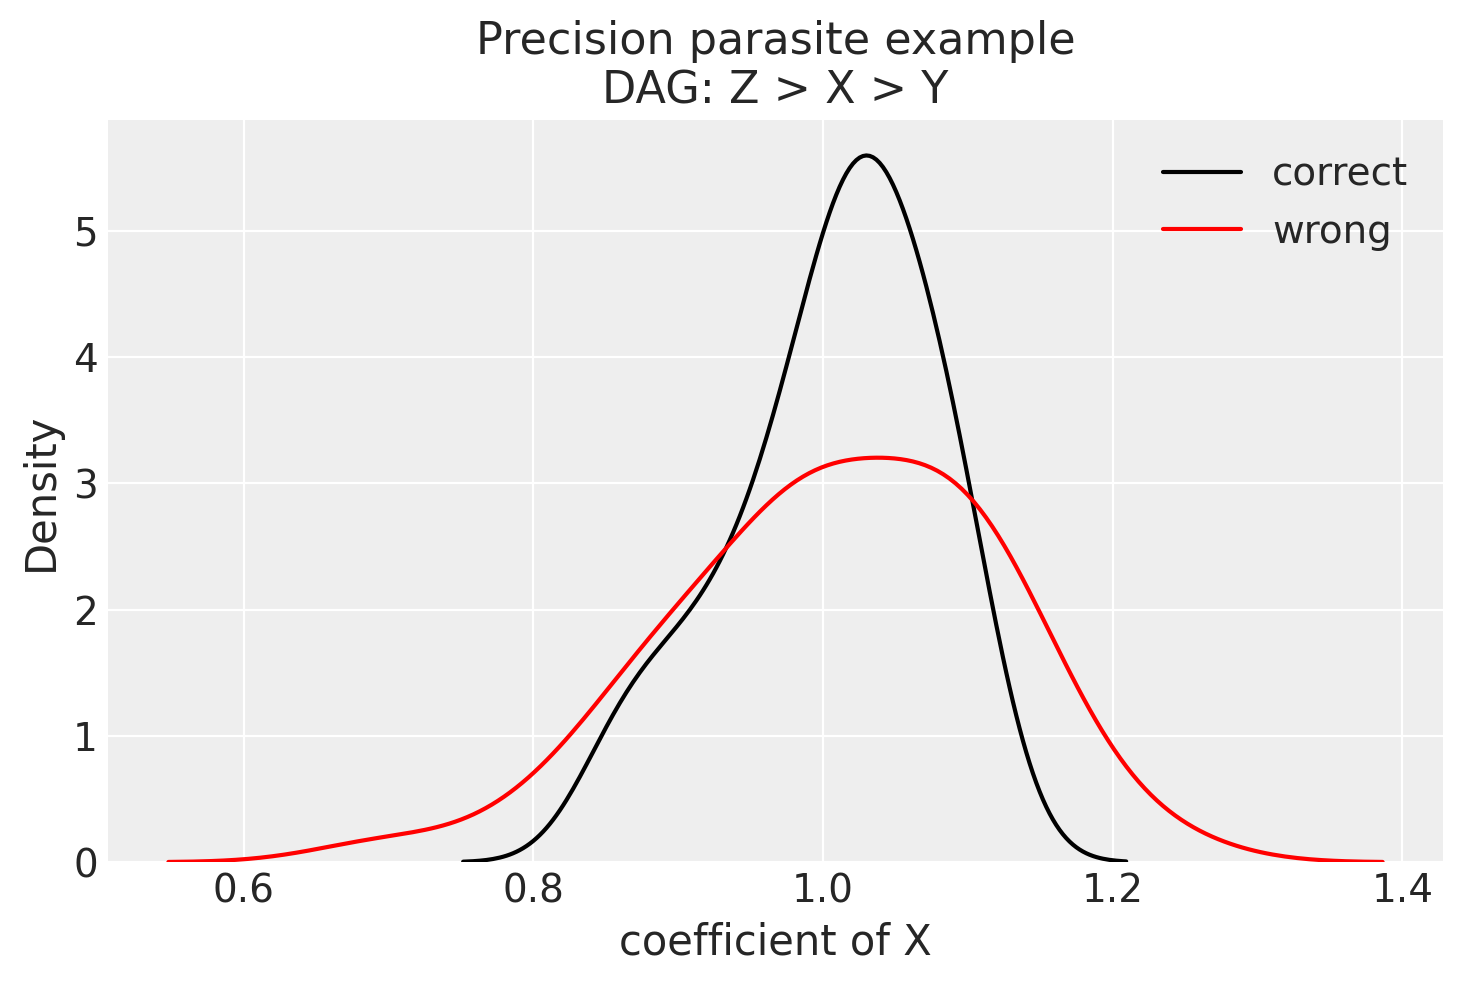

<IPython.core.display.Javascript object>

In [180]:
f, ax1 = plt.subplots()
sns.kdeplot(bX_coefs, color='k', label='correct', ax=ax1)
sns.kdeplot(bXZ_coefs, color='r', label='wrong', ax=ax1)
ax1.set(xlabel='coefficient of X', title='Precision parasite example\nDAG: Z > X > Y')
ax1.legend()

## Back to Q4

First, we need to use the DAG and simulate all the relationships. The variables that are not being acted on by anything (the exogenous variables) are u, the confound, and A. The variables acted on by other variables (endogenous) include our exposure of interest X and our outcome Y.

In [186]:
def f2(n, bAS=1, bAX=1, bSX=1, bSY=1, bAY=1, bXY=1):

    # exogenous variables
    U = stats.norm.rvs(size=n)
    A = stats.norm.rvs(size=n)

    # endogenous variables
    S = stats.norm.rvs(loc=bAS*A + U, size=n)
    X = stats.norm.rvs(loc=bSX*S + bAX*A, size=n)
    Y = stats.norm.rvs(loc=bSY*S + bAY*A + bXY*X + U, size=n)

    # using statsmodels to get coefficient
    # as we determined above, we get the estimate by conditioning on S and X
    bXAS = sm.OLS(Y, np.concatenate([X.reshape(n, 1), S.reshape(n, 1), A.reshape(n, 1)], axis=1)).fit().params[0]
    
    # get the inaccurate estimate for kicks
    bX = sm.OLS(Y, X.reshape(n, 1)).fit().params[0]
    
    return bXAS, bX

<IPython.core.display.Javascript object>

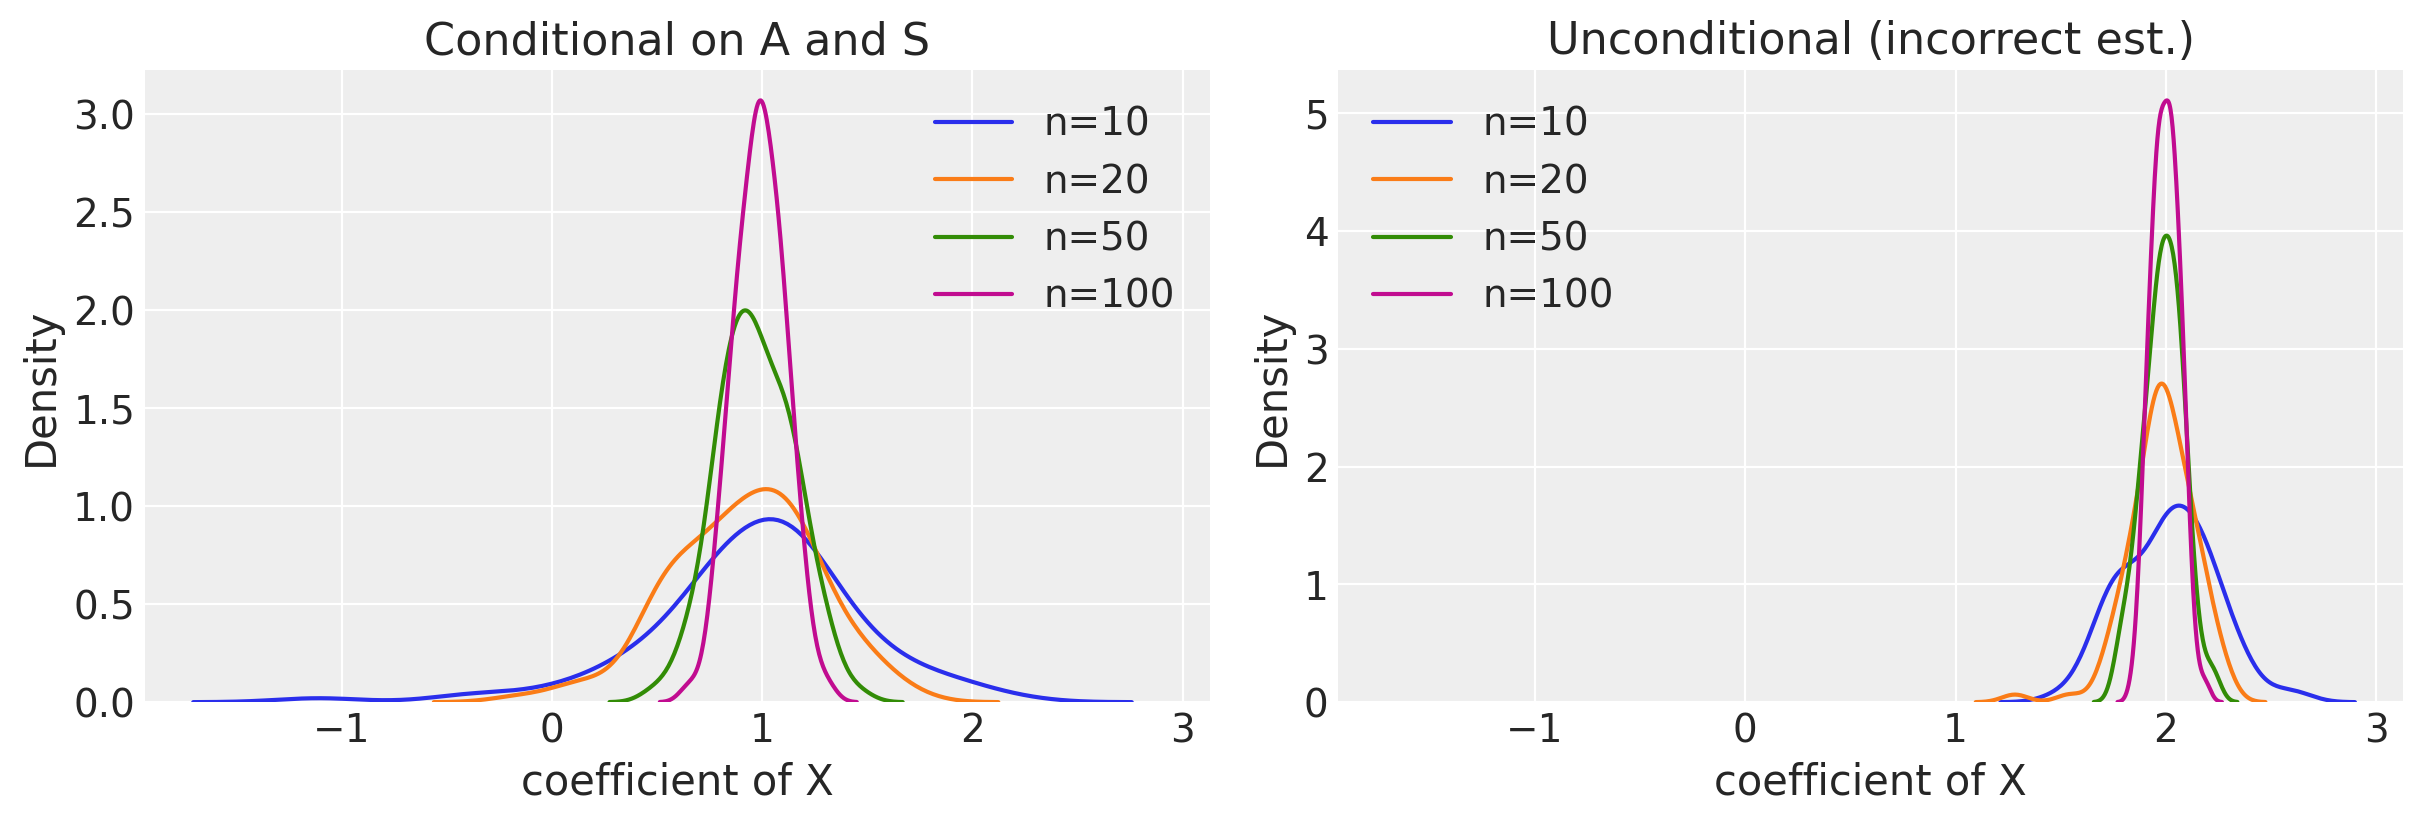

<IPython.core.display.Javascript object>

In [198]:
sample_sizes = [10, 20, 50, 100]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

for sample_size in sample_sizes:
    bXAS_coefs = list()
    bX_coefs = list()

    for i in range(100):
        bXAS, bX = f2(sample_size)
        bXAS_coefs.append(bXAS)
        bX_coefs.append(bX)

    # plot
    sns.kdeplot(bXAS_coefs, label="n=" + str(sample_size), ax=ax1)
    ax1.set(xlabel='coefficient of X', title='Conditional on A and S')
    ax1.legend()

    sns.kdeplot(bX_coefs, label="n=" + str(sample_size), ax=ax2)
    ax2.set(xlabel='coefficient of X', title='Unconditional (incorrect est.)')
    ax2.legend()

[Text(0.5, 0, 'sample size'),
 Text(0, 0.5, 'coefficient'),
 Text(0.5, 1.0, 'Effect of sample size on 89% interval for coefficient')]

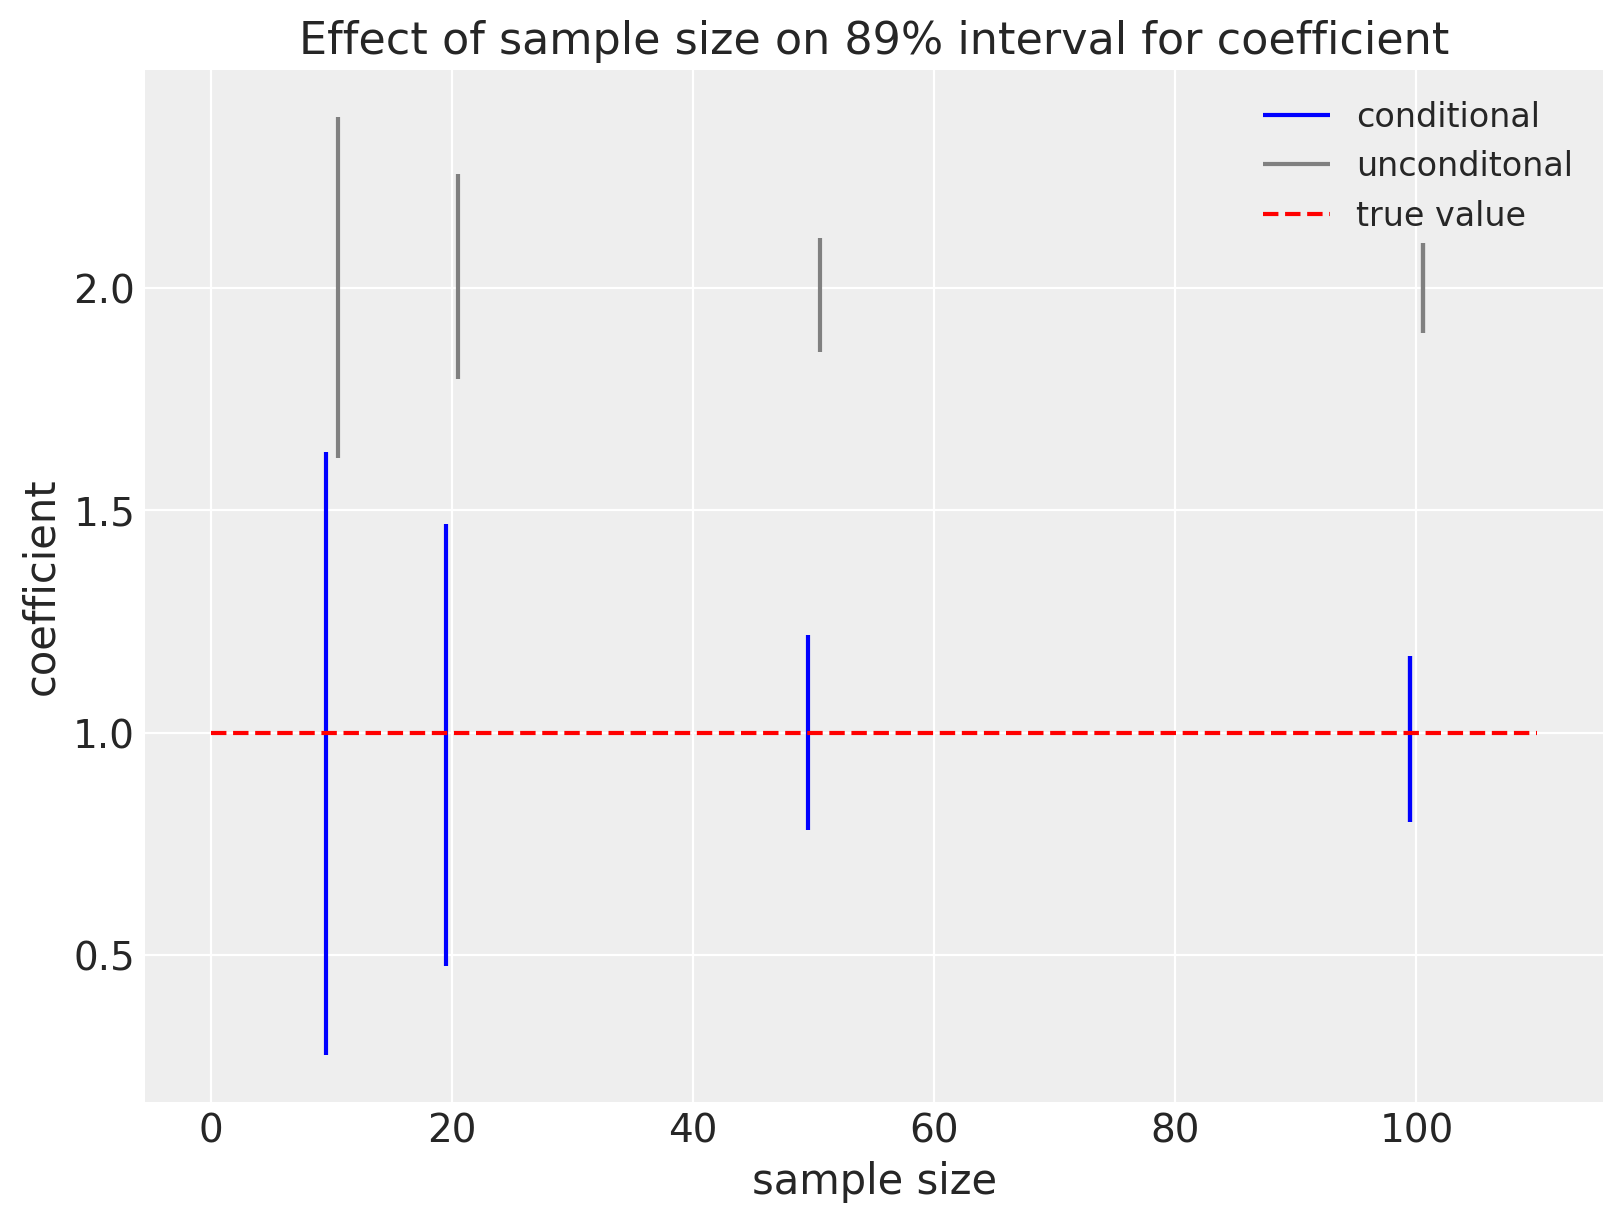

<IPython.core.display.Javascript object>

In [210]:
f, ax1 = plt.subplots(1, 1, figsize=(8, 6))

for sample_size in sample_sizes:
    bXAS_coefs = list()
    bX_coefs = list()

    for i in range(100):
        bXAS, bX = f2(sample_size)
        bXAS_coefs.append(bXAS)
        bX_coefs.append(bX)

    lower, upper = az.hdi(np.array(bXAS_coefs))
    lower_x, upper_x = az.hdi(np.array(bX_coefs))
    
    ax1.vlines(sample_size-0.5, ymin=lower, ymax=upper, color='blue')
    ax1.vlines(sample_size+0.5, ymin=lower_x, ymax=upper_x, color='gray')
    # if statement is just for labeling
    if sample_size == sample_sizes[-1]:
        ax1.vlines(sample_size-0.5, ymin=lower, ymax=upper, label='conditional', color='blue')
        ax1.vlines(sample_size+0.5, ymin=lower_x, ymax=upper_x, label='unconditonal', color='gray')

ax1.hlines(xmin=0, xmax=110, y=1, linestyle='dashed', label='true value', color='r')
ax1.legend(fontsize=12)
ax1.set(xlabel='sample size', ylabel='coefficient', title='Effect of sample size on 89% interval for coefficient')    

# Bonus bonus: visualizing correlated distributions arising from different DAGs

In [267]:
n=100

# pipe   X > Z > Y
bXZ = 1
bZY = 1

Xp = stats.norm.rvs(size=n)
Zp = stats.norm.rvs(bXZ*Xp, size=n)
Yp = stats.norm.rvs(bZY*Zp, size=n)

# fork   X < Z > Y
bZX = 1
bZY = 1

Zf = stats.norm.rvs(size=n)
Xf = stats.norm.rvs(bZX*Zp, size=n)
Yf = stats.norm.rvs(bZY*Zp, size=n)

# collider   X > Z < Y
from scipy.special import expit

bXZ = 2
bYZ = 2

Xc = stats.norm.rvs(loc=0, scale=2, size=n)
Yc = stats.norm.rvs(loc=0, scale=2, size=n)
Zc = stats.bernoulli.rvs(expit(bXZ*Xc + bYZ*Yc), size=n)

df_c = pd.DataFrame({"Xc":Xc, "Yc":Yc, "Zc":Zc})
df_c0 = df_c[df_c['Zc']==0]
df_c1 = df_c[df_c['Zc']==1]

<IPython.core.display.Javascript object>

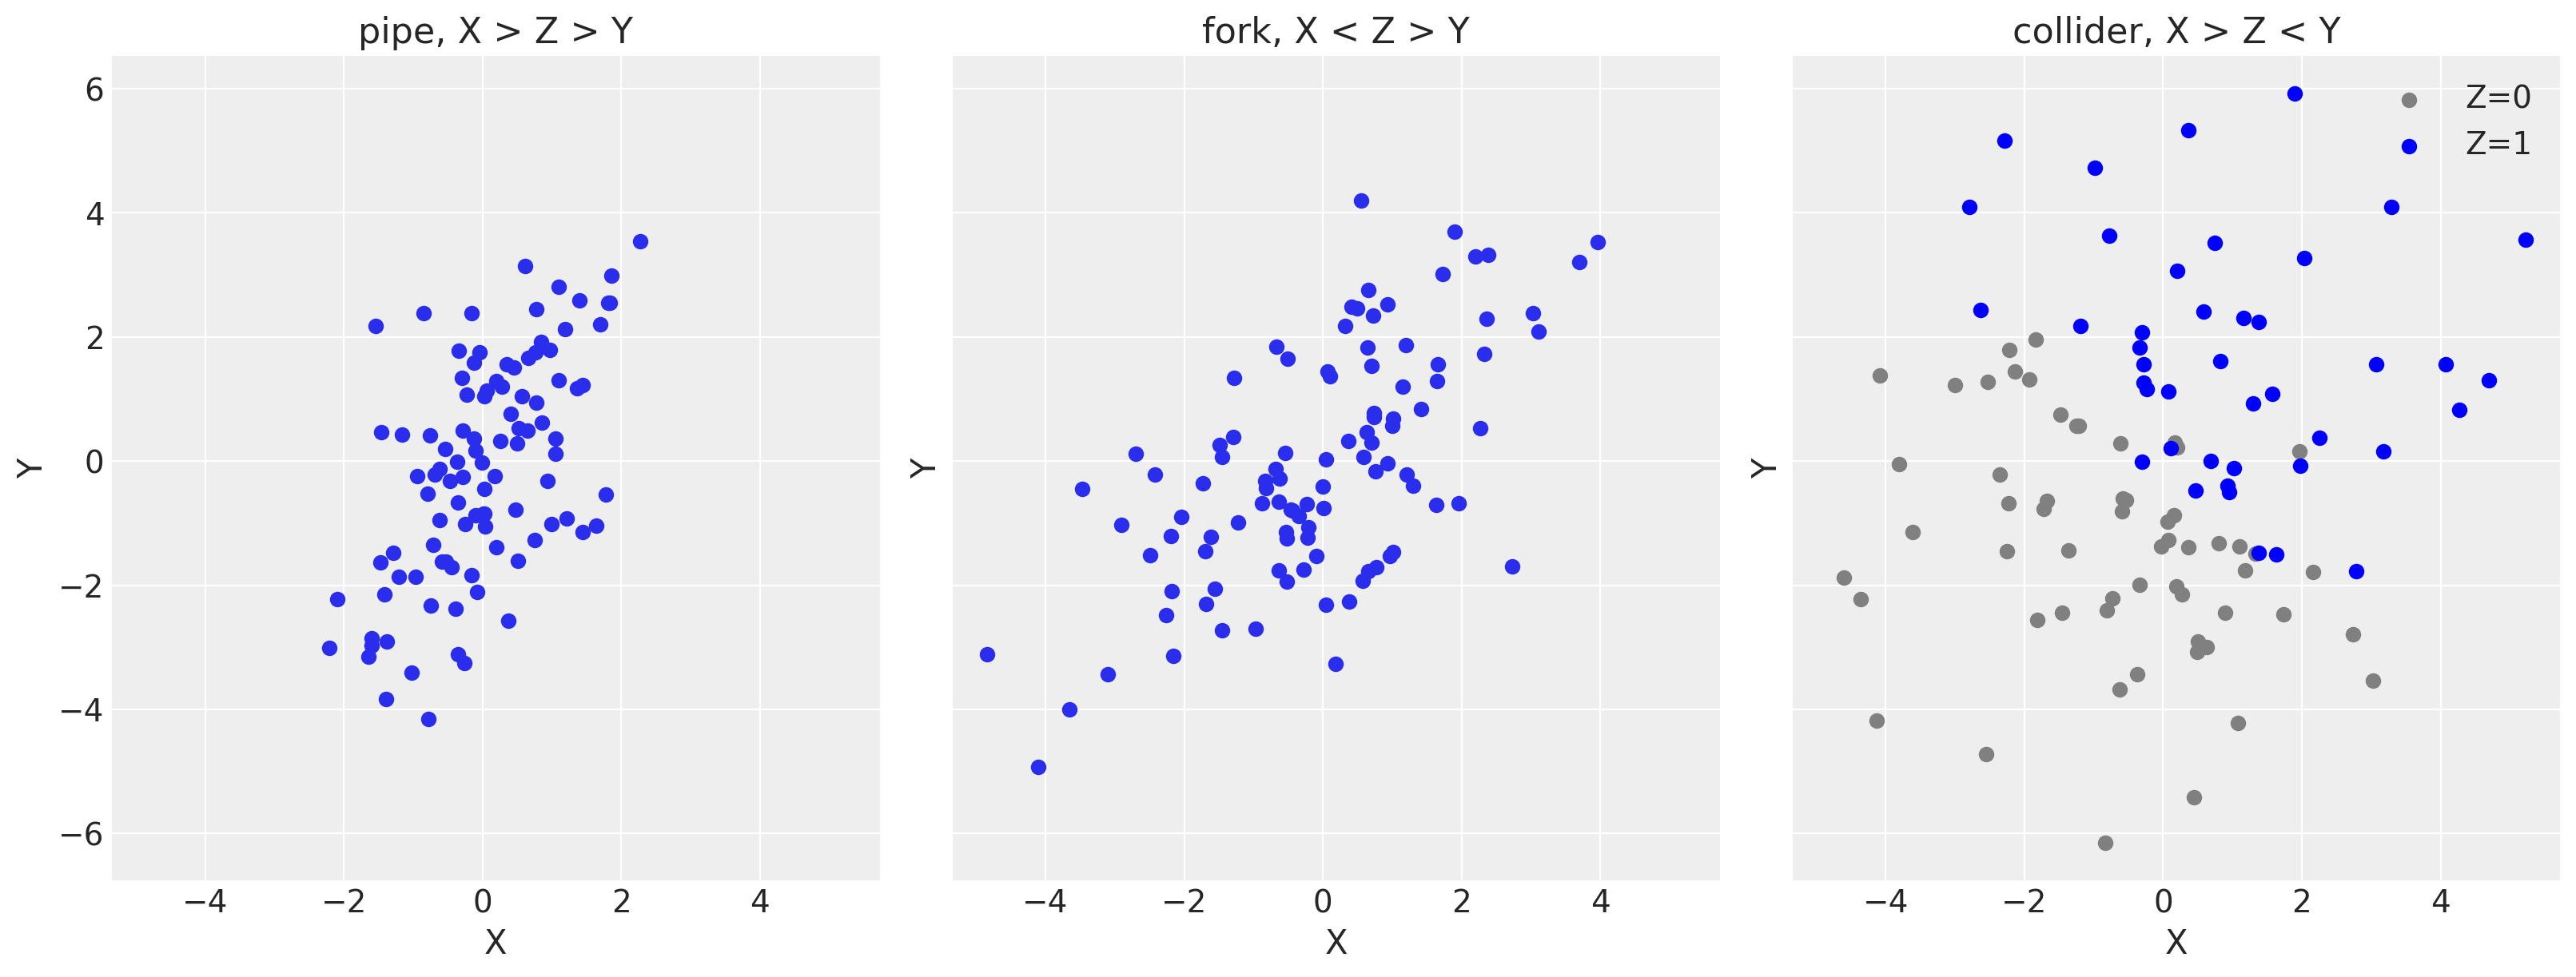

<IPython.core.display.Javascript object>

In [270]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)
ax1.scatter(Xp, Yp)
ax1.set(xlabel='X', ylabel='Y', title='pipe, X > Z > Y')

ax2.scatter(Xf, Yf)
ax2.set(xlabel='X', ylabel='Y', title='fork, X < Z > Y')

ax3.scatter(df_c0['Xc'], df_c0['Yc'], color='gray', label='Z=0')
ax3.scatter(df_c1['Xc'], df_c1['Yc'], color='blue', label='Z=1')
ax3.set(xlabel='X', ylabel='Y', title='collider, X > Z < Y')
ax3.legend()

Appendix: Environment and system parameters

In [215]:
%watermark -n -u -v -iv -w

Last updated: Tue Jan 25 2022

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy      : 1.6.0
pymc3      : 3.11.0
seaborn    : 0.11.1
daft       : 0.1.0
statsmodels: 0.12.2
matplotlib : 3.3.4
pandas     : 1.2.1
numpy      : 1.20.1
arviz      : 0.11.1
sys        : 3.8.6 | packaged by conda-forge | (default, Jan 25 2021, 23:22:12) 
[Clang 11.0.1 ]

Watermark: 2.1.0



<IPython.core.display.Javascript object>